# FDS Final project
###### Leonardo Lavagna, Edoardo Loru, Alessia Sgrigna

# Introduction

Heart Diseases and Cardiovascular Conditions are one of the leading causes of death in many countries of the world, but many of these conditions can be improved or even prevented by putting in place some changes in our daily lives. In this context having early indication of possible future Cardiovascular Problems plays a crucial role, particularly when medical data are largely available.
For this work, we will use a publicly available dataset of 11 features and 918 observations to predict whether a given patient is likely to develop some heart disease, making use of several well known techniques – such as feature scaling and dimensionality reduction – and models – such as Logistic Regression and k-Nearest Neighbors.

The dataset was prepared and made available by the user `fedesoriano` on Kaggle, and it's downloadable at this link:

www.kaggle.com/fedesoriano/heart-failure-prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as m
pd.options.mode.chained_assignment = None

sns.set()

In [2]:
df = pd.read_csv("data/heart_fedesoriano.csv", header="infer")

print(df.shape)
df.head()

(918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Preprocessing

Before doing any kind of modelling, analysing and cleaning the data we are dealing with is of vital importance.

In [3]:
# proprocessed dataframe
dataset = df.copy()

### Features

As we can see this dataset has a mixture of numerical and categorical data: this is something we will need to deal with when preparing the data for modelling.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
features = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope", "Age", "MaxHR", "Cholesterol", "Oldpeak", \
            "RestingBP", "FastingBS", "HeartDisease"]

In [6]:
categorical_features = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope", "FastingBS"]
numerical_features   = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

Let's go through each of the available features in detail

- `Age`: age of the patient [years]
- `Sex`: sex of the patient [M: Male, F: Female]
- `ChestPainType`: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- `RestingBP`: resting blood pressure [mm Hg]
- `Cholesterol`: serum cholesterol [mm/dl]
- `FastingBS`: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- `RestingECG`: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- `MaxHR`: maximum heart rate achieved [Numeric value between 60 and 202]
- `ExerciseAngina`: exercise-induced angina [Y: Yes, N: No]
- `Oldpeak`: oldpeak = ST [Numeric value measured in depression] (0 corresponds to a normal value)
- `ST_Slope`: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

We also have a column with the actual diagnosis for every observation, which we are going to use to train our models and check their accuracy.
- `HeartDisease`: output class [1: Heart Disease, 0: Normal]

In [7]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


## Missing Values

The first issue we need to address are missing measurements in the observations. We will check for each feature if there are unexpected values

In [8]:
for item in categorical_features:
    print(item,len(df[item].unique()))
print("\nNo unexpected values")

Sex 2
ChestPainType 4
RestingECG 3
ExerciseAngina 2
ST_Slope 3
FastingBS 2

No unexpected values


In [9]:
for item in numerical_features[0:-1]:
    print(item, np.count_nonzero(dataset[item]==0))
print("\nUnexpected values in RestingBP and Cholesterol")

Age 0
RestingBP 1
Cholesterol 172
MaxHR 0

Unexpected values in RestingBP and Cholesterol


In [10]:
count = 0
for item in dataset['MaxHR'].T:
    if dataset['MaxHR'][item]< 60 or df['MaxHR'][item]> 202:
        count += 1
print(count)
print("\nNo unexpected values")

0

No unexpected values


## Cleaning and Filling

We will now address all the unexpected values, in particular we will find and replace the zeros in `RestingBP` and `Cholesterol`.

We will replace the single zero value in `RestingBP` with the mean of the column

In [11]:
dataset["RestingBP"][np.argmin(dataset["RestingBP"])] = np.mean(dataset["RestingBP"])

Let's now focus on the `Cholesterol`feature.

Out of the 918 observations, 172 of them have a cholesterol value of 0; this is clearly not an actual measurement, rather a missing one, so we need to fill in those values.

A reasonable choice is to sample them from the empirical distribution of this dataset.

In [12]:
df["Cholesterol"].value_counts()

0      172
254     11
223     10
220     10
230      9
      ... 
392      1
316      1
153      1
466      1
131      1
Name: Cholesterol, Length: 222, dtype: int64

In [13]:
import random
from scipy.stats import t

def filling(data,alpha,val):
    """
    Function to fill the missing values of the 'Cholesterol' column
    """
    
    list_ = []
    n = len(data.Cholesterol) - np.count_nonzero(data['Cholesterol']==0)
    deg = n - 1
    
    avg = data.Cholesterol.sum()/n
    svar = np.var(data.Cholesterol)
        
    min_ = avg - t.pdf(alpha/2, deg)*svar/n
    max_ = avg + t.pdf(alpha/2, deg)*svar/n
    
    data.Cholesterol[val] = random.uniform(min_,max_)
    list_.append(data.Cholesterol[val])

chol_series = pd.Series(dataset['Cholesterol']==0)
chol_vals = list(chol_series.to_numpy().nonzero())

for val in chol_vals[0]:
    filling(data=dataset,alpha=0.2,val=val)

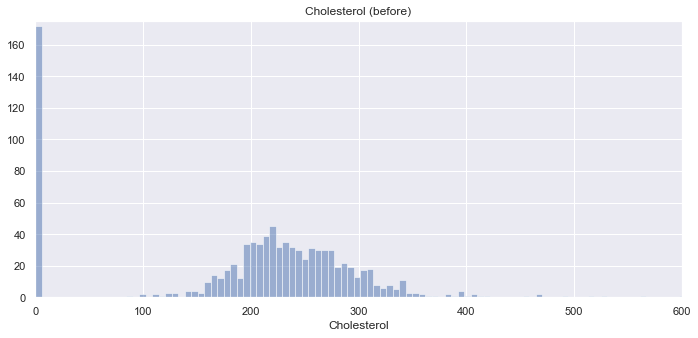

In [14]:
fig = plt.figure(figsize=(10,5))
plt.hist(df["Cholesterol"], bins=100, alpha =.5, label="Cholesterol")
axes = plt.gca()
axes.set_xlim([0,600])
axes.set_ylim([0,175])
plt.title("Cholesterol (before)")
plt.xlabel("Cholesterol")
fig.tight_layout(pad=1.5)
plt.show()

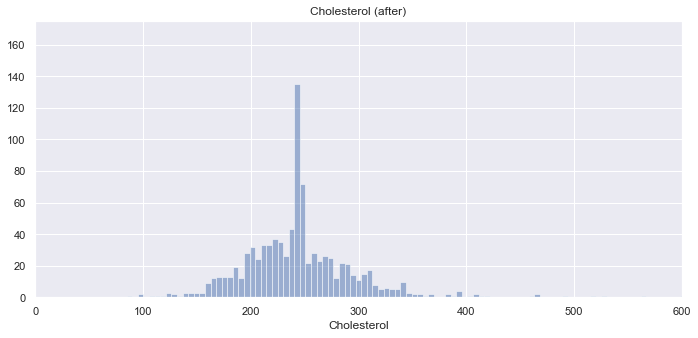

In [15]:
fig = plt.figure(figsize=(10,5))
plt.hist(dataset["Cholesterol"], bins=100, alpha =.5, label="Cholesterol")
axes = plt.gca()
axes.set_xlim([0,600])
axes.set_ylim([0,175])
plt.title("Cholesterol (after)")
plt.xlabel("Cholesterol")
fig.tight_layout(pad=1.5)
plt.show()

# Exploratory Data Analysis

Now that we have filled in the missing values, let's a take a closer look at how the features are distributed and how they interact with each other. By doing so, we may gain useful insights not only on the dataset itself but also more generally on what features may have a greater impact on the disease (or lack thereof).

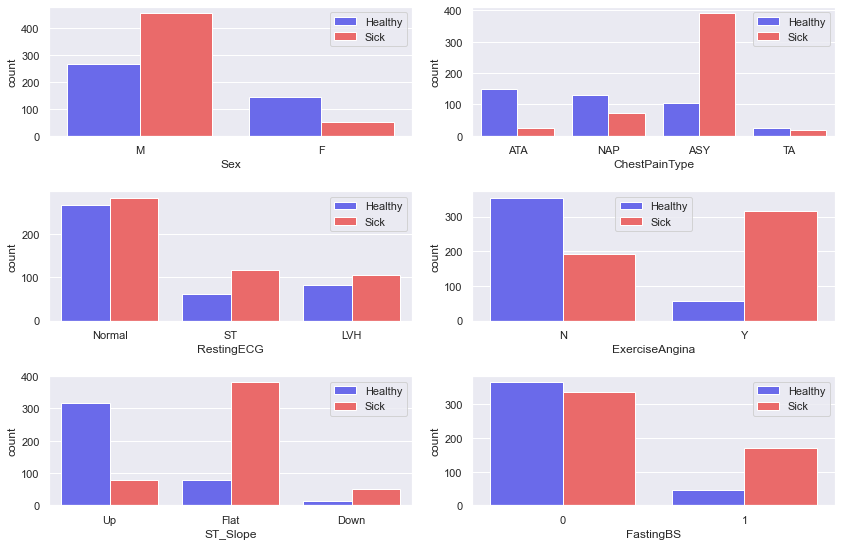

In [16]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca()

counter = 1
for feature in categorical_features:
    
    plt.subplot(420 + counter)
    counter +=1

    sns.countplot(x=dataset[feature], hue=dataset["HeartDisease"], palette="seismic")
    plt.legend(["Healthy","Sick"])

fig.tight_layout(pad=1.5) 
plt.show()

These barplots definitely show some interesting correlations: most people that were diagnosed with some heart disease
- were male
- were asymptomatic
- experienced exercise-induced angina
- had a flat ST slope

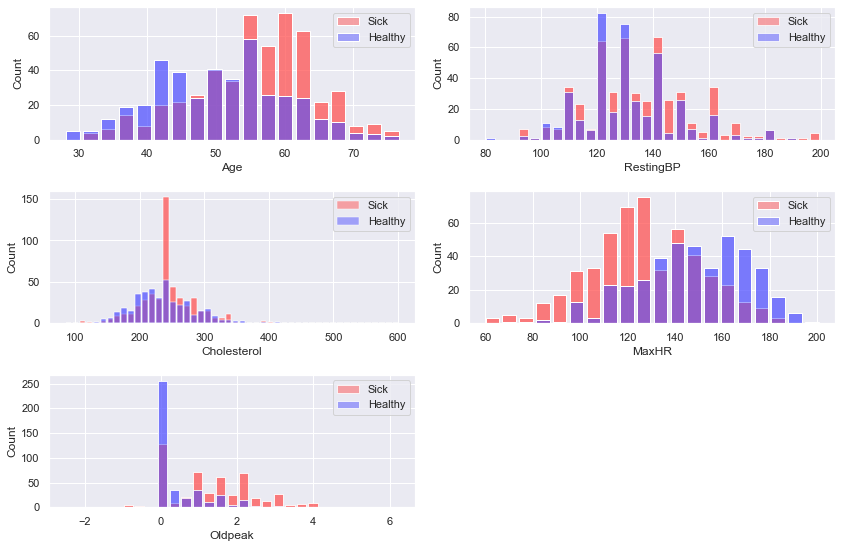

In [17]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca()

counter = 1
for dimension in numerical_features:
    
    plt.subplot(420+counter)
    counter +=1
    
    for item in dataset.HeartDisease.unique():
        sns.histplot(x=dataset[dimension], hue=dataset["HeartDisease"], palette="seismic",shrink=0.8)
        plt.legend(["Sick", "Healthy"])
        plt.xlabel(dimension)
        
fig.tight_layout(pad=1.5)
plt.show()

Looking at the distribution of the numerical features the distinction is not as clear. With that being said, we can definitely say that most of the people diagnosed with a heart disease
- were older than average
- had a lower maximum number of heartbeats
- had a slightly above average cholesterol

By what we have seen in the previous analysis, the feature `ChestPainType` plays a particular role: the patient with `ChestPainType` equal to `ASY` (as in *asymptomatic*) seems more likely to show a heart condition. This is why we choose to focus on this particular feature a little more. In particular, we ask, is this feature alone a good predictor, or there is some sort of selection bias? For example is there a significant difference in Age among the patients with different kinds of chest pain type?

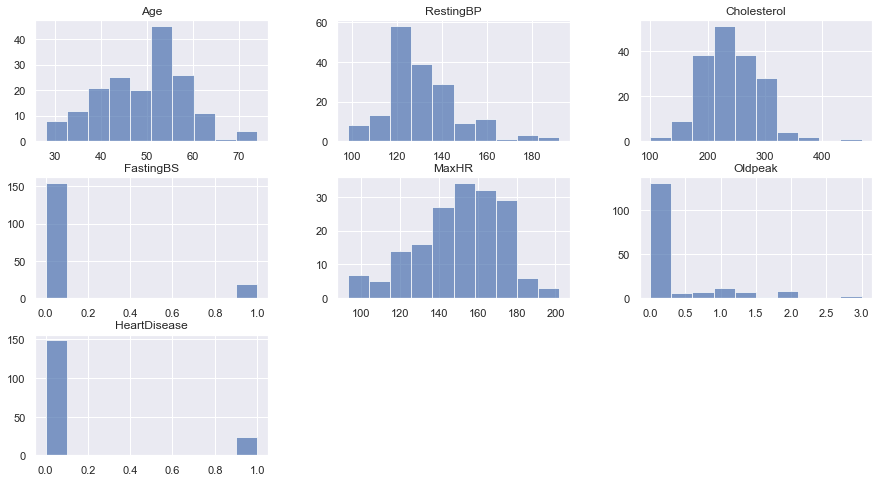

In [18]:
dataset[dataset["ChestPainType"]=="ATA"].hist(alpha=0.7,figsize=(15, 8))
plt.show()

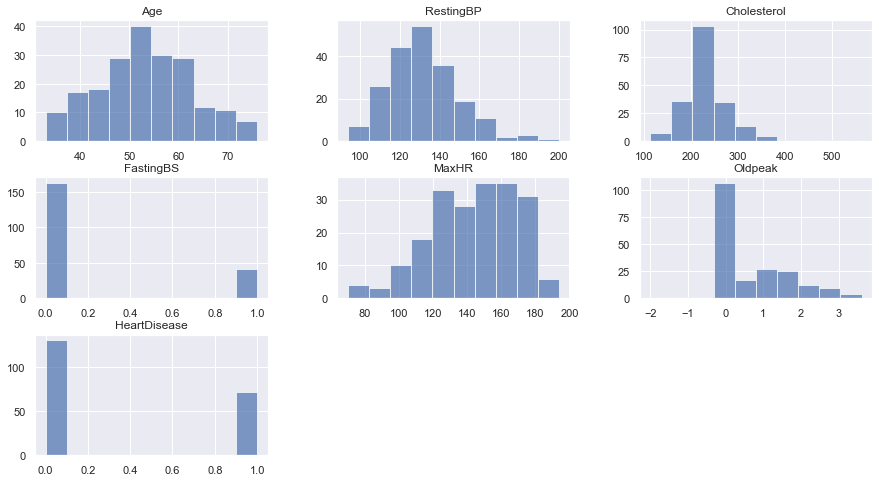

In [19]:
dataset[dataset["ChestPainType"]=="NAP"].hist(alpha=0.7,figsize=(15, 8))
plt.show()

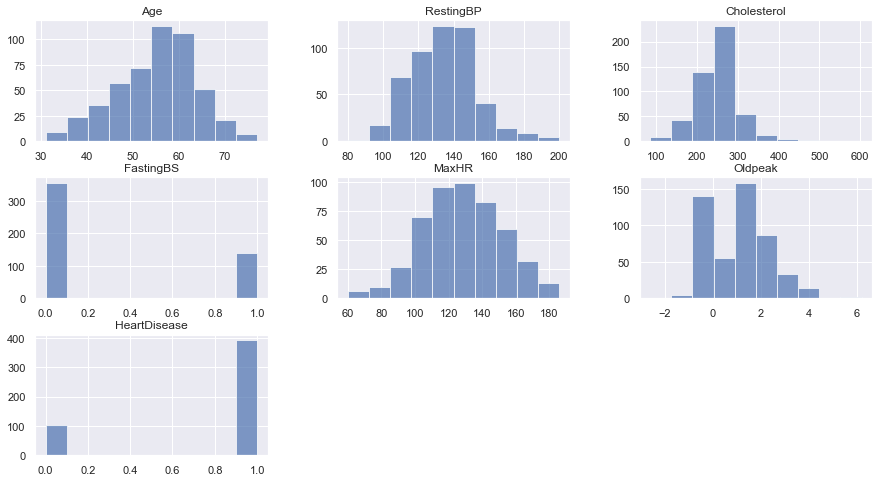

In [20]:
dataset[dataset["ChestPainType"]=="ASY"].hist(alpha=0.7,figsize=(15, 8))
plt.show()

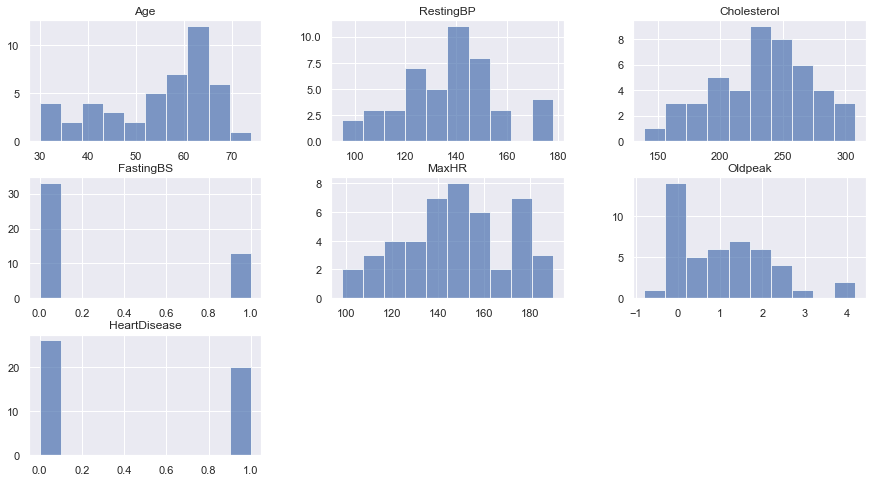

In [21]:
dataset[dataset["ChestPainType"]=="TA"].hist(alpha=0.7,figsize=(15, 8))
plt.show()

It seems that the most significant difference among the patients with different chest pain types is in the `Oldpeak` column, but an Oldpeak near zero is the normality. It seems that a combination of normal values for Oldpeak an absence of chest pain can increase the probability of developing an heart disease, which is bizarre. 

Finally, how are these features correlated with each other?

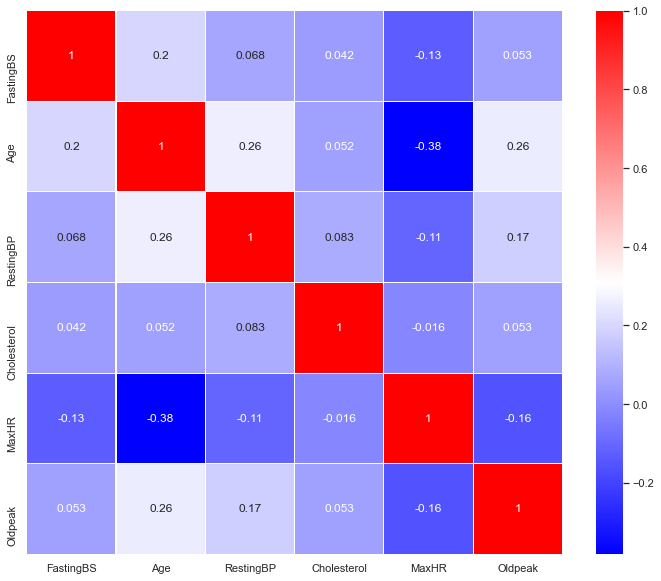

In [22]:
corr = dataset[categorical_features + numerical_features].corr()
plt.figure(figsize = (12,10))
sns.heatmap(corr, annot = True, cmap="bwr",linewidths=.1)
plt.show()

The linear correlation is very close to zero for most of the pairs. `Age` seems to be the feature which is most correlated to the rest, especially to `MaxHR`, with which it has a negative correlation.

# Models

In [23]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [24]:
def train_model(model, X, y, split=0.30):
    """
    Trains the given model with the given data
    and returns the true labels, the predicted labels
    and the probabilities
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=0)
    
    classifier = model.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    
    y_score = classifier.predict_proba(X)[:, 1]
    
    return y_test, y_pred, y_score


def kfold(model, X, y, splits=5):
    """
    Performs k-fold cross validation of the given model
    with the given data and returns the mean accuracy
    and sensitivity obtained
    """
    
    kf = KFold(n_splits=5)
    
    accs = []
    senss = []
    
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]

        classifier = model.fit(X_train, y_train)
        
        y_pred = classifier.predict(X_test)
    
        acc, sens = conf_mat(y_test, y_pred)
        
        accs.append(acc)
    
        senss.append(sens)
    
    return np.mean(accs), np.mean(senss)


def conf_mat(y_test, y_pred, plot=False):
    """
    Generate a confusion matrix with the true and the predicted labels
    and plots the results as a heatmap, returning the accuracy and
    the sensitivity
    
    The following code was inspired by this
    https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
    """

    conf_mat = confusion_matrix(y_test, y_pred)

    acc = 100 * metrics.accuracy_score(y_test, y_pred)
    sens = 100 * (1 - conf_mat[1][0] / sum(conf_mat[1]))
    
    if plot:
        group_names = ["True Neg","False Pos","False Neg","True Pos"]
        
        group_counts = ["{0:0.0f}".format(value) for value in
                        conf_mat.flatten()]
        
        group_percentages = ["{0:.2%}".format(value) for value in
                             conf_mat.flatten()/np.sum(conf_mat)]
        
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
                  zip(group_names,group_counts,group_percentages)]
        
        labels = np.asarray(labels).reshape(2,2)
        
        sns.heatmap(conf_mat, annot=labels, fmt="", cmap='Blues')
        
        plt.xlabel(f"Accuracy:  {acc:.2f}%\nSensitivity: {sens:.2f}%")

    return acc, sens

We will train differrent models on the dataset and we will observe the results in terms of two metrics: the **accuracy** (i.e. the rate of correct predictions) and the **sensitivity** (i.e. 1 minus the rate of false negatives).

We will try:
- Decision Tree
- KNN
- Logistic Regression
- Gaussian Naïve Bayes

and for each check whether they work best with all data or with a reduced dataset through PCA.

Finally, we will check the validity of the results with k-fold Cross Validation.

## Decision Tree

We train (using standard Python libraries) a Decision Tree model, namely flowchart-like structure in which each internal node represents a "test" on an attribute, and each branch represents the outcome of the test, where each leaf will be a class label (decision taken after computing all attributes). The paths from root to leaf represent classification rules.

We call `dataset_dt` the modified dataset for this model.

In [25]:
dataset_dt = dataset.copy()

Let's transform the categorical features in dummy variables (one-hot encoding)

In [26]:
dataset_dt = pd.get_dummies(dataset_dt, columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])
dataset_dt.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


Usually Decision Tree performs best with non-standardized data, so let's see what metrics we get with the complete dataset as we have just modified it.

The training will be done on 70% on the dataset (with the remaining 30% left for testing).

In [27]:
y = dataset_dt['HeartDisease']
X = dataset_dt.drop(['HeartDisease'], axis=1)

First, let's see how the maximum number of features the classifier will use will affect its score.

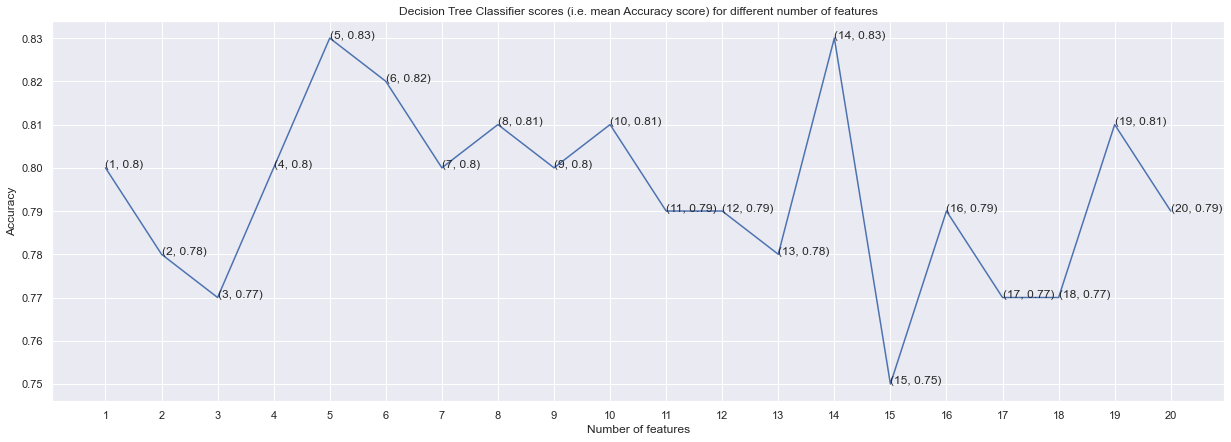

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)

dt_scores = []
for i in range(1, len(X.columns) + 1):
    dt_classifier = DecisionTreeClassifier(max_features = i, random_state = 0)
    dt_classifier.fit(X_train, y_train)
    dt_scores.append(round(dt_classifier.score(X_test, y_test),2))

plt.figure(figsize=(21, 7))
plt.plot([i for i in range(1, len(X.columns) + 1)], dt_scores)
for i in range(1, len(X.columns) + 1):
    plt.text(i, dt_scores[i-1], (i, dt_scores[i-1]))
plt.xticks([i for i in range(1, len(X.columns) + 1)])
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Decision Tree Classifier scores (i.e. mean Accuracy score) for different number of features')
plt.show()

Let's see what sensitivity we get using `max_features=6`

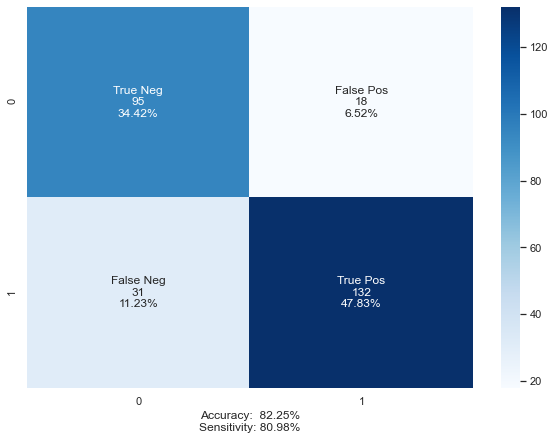

In [29]:
model = DecisionTreeClassifier(max_features=6, random_state=0)

y_test, y_pred, y_score_dt = train_model(model, X, y)

# confusion matrix
plt.figure(figsize=(10,7))
conf_mat(y_test, y_pred, plot=True)
plt.show()

Let's try to improve it by grouping together all symptomatic chest pain types (i.e. TA, ATA, NAP).

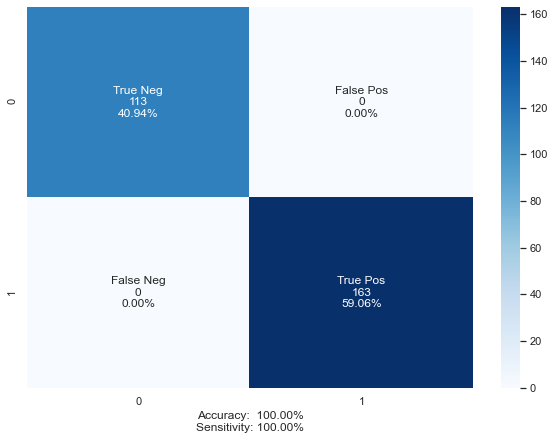

In [30]:
dataset_dt["ChestPainType_SYM"] = dataset_dt["ChestPainType_ATA"] + dataset_dt["ChestPainType_TA"] + dataset_dt["ChestPainType_NAP"]

dataset_dt = dataset_dt.drop(['ChestPainType_ATA', "ChestPainType_TA", "ChestPainType_NAP"], axis = 1)

model = DecisionTreeClassifier(max_features=6, random_state=0)

X = dataset_dt.copy()
y_test, y_pred, y_score_dt = train_model(model, X, y)

# confusion matrix
plt.figure(figsize=(10,7))
conf_mat(y_test, y_pred, plot=True)
plt.show()

The improvement is astonishing: all labels were correctly predicted.

Let's see whether these figures hold with k-fold cross validation, with $k=5$.

In [31]:
model = DecisionTreeClassifier(max_features=6, random_state=0)

mean_acc, mean_sens = kfold(model, X, y)

print(f"Mean Accuracy:    {mean_acc:.2f}%")
print(f"Mean Sensitivity: {mean_sens:.2f}%")

Mean Accuracy:    99.46%
Mean Sensitivity: 99.42%


To our surprise the metrics hold: both accuracy and sensitivity still exceed our expectations.

## KNN

In the K-Nearest Neighbors algorithm for Clustering the training examples are vectors in a multidimensional feature space, each with a class label. The training phase of the model then consists only of storing the feature vectors and class labels of the training samples, then in the classification process, given a positive integer $k$, an unlabeled vector is classified by assigning the label which is most frequent among the $k$ training samples nearest to that query point.

We call `dataset_knn` the modified dataset for this model.

In [32]:
dataset_knn = dataset.copy()

Let's standardize the data so it has zero mean and unity variance, and then split it into 70% for training and 30% for testing, having first converted all categorical features into dummy variables and having grouped the chest pain types as we did earlier with Decision Tree.

In [33]:
dataset_knn = pd.get_dummies(dataset_knn, columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])
dataset_knn["ChestPainType_SYM"] = dataset_knn["ChestPainType_ATA"] + dataset_knn["ChestPainType_TA"] + dataset_knn["ChestPainType_NAP"]
dataset_knn = dataset_knn.drop(['ChestPainType_ATA', "ChestPainType_TA", "ChestPainType_NAP"], axis = 1)

std_scaler = StandardScaler()
dataset_knn_std = pd.DataFrame(std_scaler.fit_transform(dataset_knn.drop("HeartDisease", axis="columns")), 
                               columns=dataset_knn.columns[:-1]).fillna(value=0)

X = dataset_knn_std.copy()
y = dataset_knn['HeartDisease']

First, let's see what number of neighbors gives us the best accuracy.

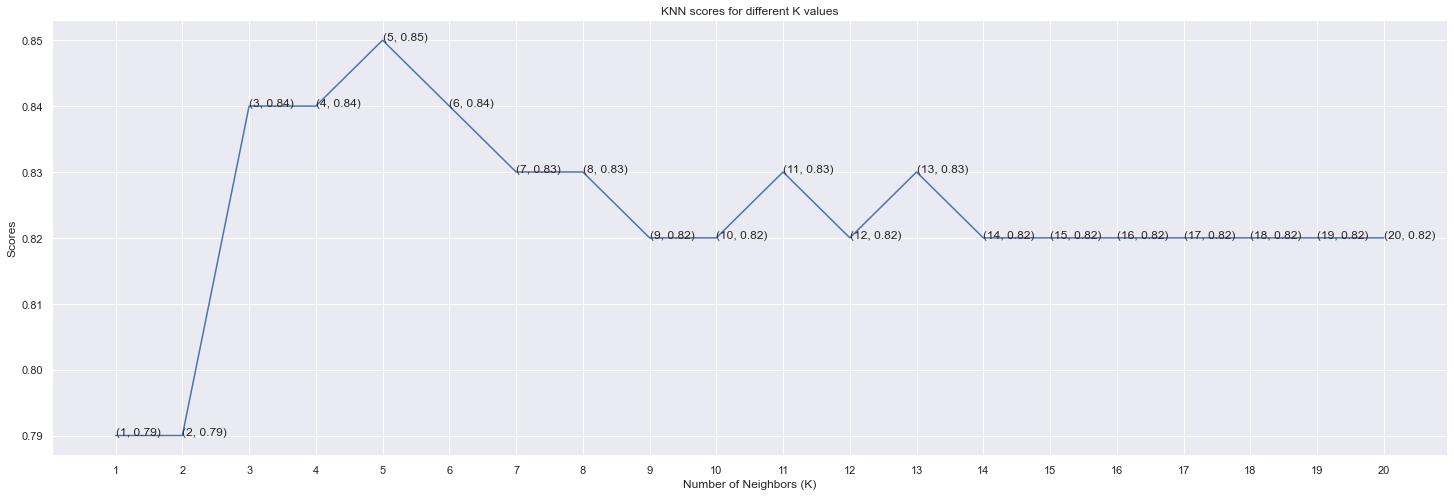

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

knn_scores = []

for k in range(1,21):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)
    knn_scores.append(round(knn_classifier.score(X_test, y_test), 2))

plt.figure(figsize=(25, 8))
plt.plot([k for k in range(1, 21)], knn_scores)
for i in range(1,21):
    plt.text(i, knn_scores[i-1], (i, knn_scores[i-1]))
plt.xticks([i for i in range(1, 21)])
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Scores')
plt.title('KNN scores for different K values')
plt.show()

All $k\geq3$ seem like a good choice; let's see what sensitivity we get with $k=5$.

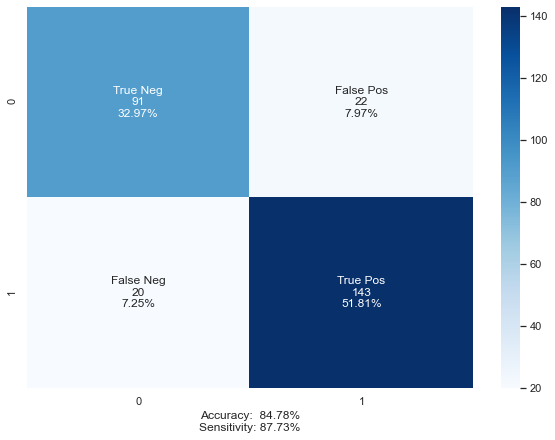

In [35]:
model = KNeighborsClassifier(n_neighbors=5)

y_test, y_pred, y_score_knn = train_model(model, X, y)

# confusion matrix
plt.figure(figsize=(10,7))
conf_mat(y_test, y_pred, plot=True)
plt.show()

The results are very good, but not comparable to Decision Tree.

Let's see whether we can improve them any further by using fewer features of the dataset.

Since most features are interconnected we don't think it's reasonable to manually select which to exclude; instead we could peform a PCA and see whether by only training KNN with the first few components (equivalent to 70% total retained variance) we get better metrics.

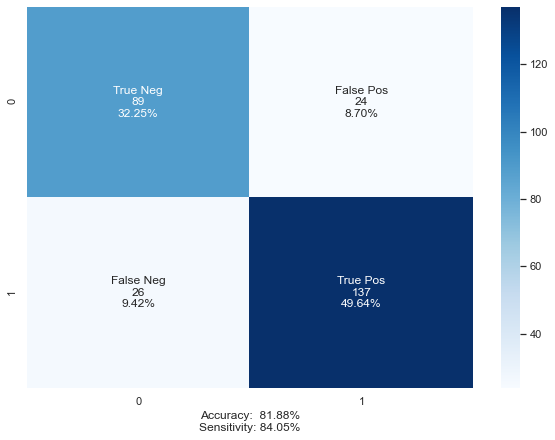

In [36]:
# dimensionality reduction
pca = PCA(0.70)
dataset_knn_pca = pd.DataFrame(pca.fit_transform(dataset_knn_std), 
                               columns = [f"Feature_{i}" for i in range(len(pca.components_))])

X = dataset_knn_pca.copy()
y = dataset_knn['HeartDisease']

model = KNeighborsClassifier(n_neighbors=5)

y_test, y_pred, _ = train_model(model, X, y)

# confusion matrix
plt.figure(figsize=(10,7))
conf_mat(y_test, y_pred, plot=True)
plt.show()

These results are not as good as those we got without PCA, so we won't go any further with dimensionality reductions.

Finally, let's perform k-fold cross validation with $k=5$ on the non-reduced dataset `dataset_knn_std`.

In [37]:
X = dataset_knn_std.copy()
y = dataset_knn['HeartDisease']

model = KNeighborsClassifier(n_neighbors=5)

mean_acc, mean_sens = kfold(model, X, y)

print(f"Mean Accuracy:    {mean_acc:.2f}%")
print(f"Mean Sensitivity: {mean_sens:.2f}%")

Mean Accuracy:    84.42%
Mean Sensitivity: 86.94%


Cross validation confirms the results we got earlier on the 30% test from `dataset_knn_std`.

## Logistic Regression

Logistic regression measures the relationship between the categorical dependent variable and one or more independent variables by estimating probabilities using a logistic function, which is the cumulative distribution function of logistic distribution. We will apply this model to  `dataset_lr` which is appropriately modified from the original dataset.

In [38]:
dataset_lr = dataset.copy()

We'll reserve to the data the same treatment as for KNN: convert categorical data into dummy variables, group the chest pain types into two features, and finally standardize.

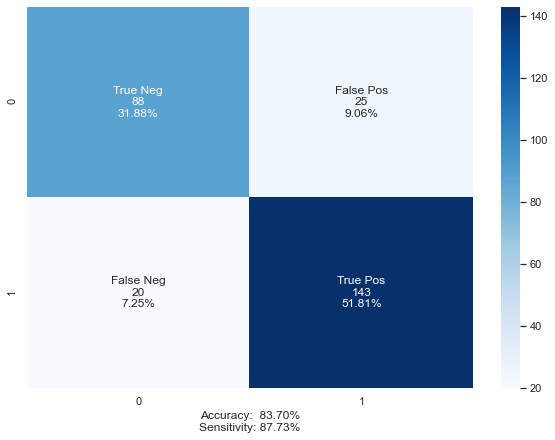

In [39]:
dataset_lr = pd.get_dummies(dataset_lr, columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])
dataset_lr["ChestPainType_SYM"] = dataset_lr["ChestPainType_ATA"] + dataset_lr["ChestPainType_TA"] + dataset_lr["ChestPainType_NAP"]
dataset_lr = dataset_lr.drop(['ChestPainType_ATA', "ChestPainType_TA", "ChestPainType_NAP"], axis = 1)

std_scaler = StandardScaler()
dataset_lr_std = pd.DataFrame(std_scaler.fit_transform(dataset_lr.drop("HeartDisease", axis="columns")), 
                               columns=dataset_lr.columns[:-1]).fillna(value=0)

X = dataset_lr_std.copy()
y = dataset_lr['HeartDisease']

model = LogisticRegression(random_state = 0)

y_test, y_pred, y_score_lr = train_model(model, X, y)

# confusion matrix
plt.figure(figsize=(10,7))
conf_mat(y_test, y_pred, plot=True)
plt.show()

The figures we get are very comparable to KNN's.

Let's see whether we can improve them by PCA.

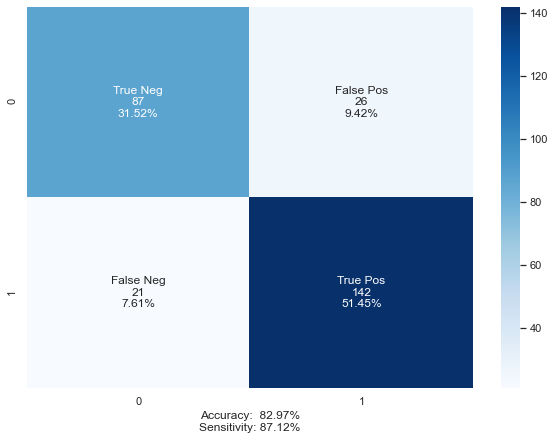

In [40]:
# dimensionality reduction
pca = PCA(0.70)
dataset_lr_pca = pd.DataFrame(pca.fit_transform(dataset_lr_std), 
                               columns = [f"Feature_{i}" for i in range(len(pca.components_))])

X = dataset_lr_pca.copy()
y = dataset_lr['HeartDisease']

model = LogisticRegression(random_state = 0)

y_test, y_pred, _ = train_model(model, X, y)

# confusion matrix
plt.figure(figsize=(10,7))
conf_mat(y_test, y_pred, plot=True)
plt.show()

The results are identical except for two labels. 

Finally, let's check whether k-fold cross validation with $k=5$ confirms them.

In [41]:
X = dataset_lr_std.copy()
y = dataset_lr['HeartDisease']

model = LogisticRegression(random_state = 0)

mean_acc, mean_sens = kfold(model, X, y)

print(f"Mean Accuracy:    {mean_acc:.2f}%")
print(f"Mean Sensitivity: {mean_sens:.2f}%")

Mean Accuracy:    84.52%
Mean Sensitivity: 85.85%


## Gaussian Naïve Bayes

A Naïve Bayes classifier assumes indipendence between features given the class; in the case of a Gaussian NB, the features are also assumed to be Normally distributed. As we saw in the EDA, many of the features are distributed in a bell shape, so this model may work well.

We call `dataset_gnb` the modified dataset for this model.

In [42]:
dataset_gnb = dataset.copy()

As we did before we one-hot encode all categorical features, group the chest pain type in asymptomatic and symptomatic and finally standardize all data.

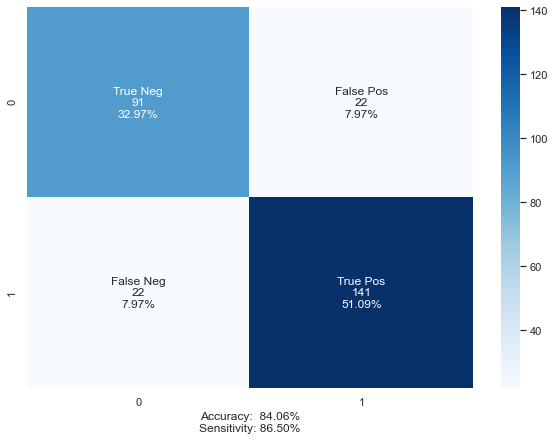

In [43]:
dataset_gnb = pd.get_dummies(dataset_gnb, columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])
dataset_gnb["ChestPainType_SYM"] = dataset_gnb["ChestPainType_ATA"] + dataset_gnb["ChestPainType_TA"] + dataset_gnb["ChestPainType_NAP"]
dataset_gnb = dataset_gnb.drop(['ChestPainType_ATA', "ChestPainType_TA", "ChestPainType_NAP"], axis = 1)

std_scaler = StandardScaler()
dataset_gnb_std = pd.DataFrame(std_scaler.fit_transform(dataset_gnb.drop("HeartDisease", axis="columns")), 
                               columns=dataset_gnb.columns[:-1]).fillna(value=0)

X = dataset_gnb_std.copy()
y = dataset_gnb['HeartDisease']

model = GaussianNB()

y_test, y_pred, y_score_gnb = train_model(model, X, y)

# confusion matrix
plt.figure(figsize=(10,7))
conf_mat(y_test, y_pred, plot=True)
plt.show()

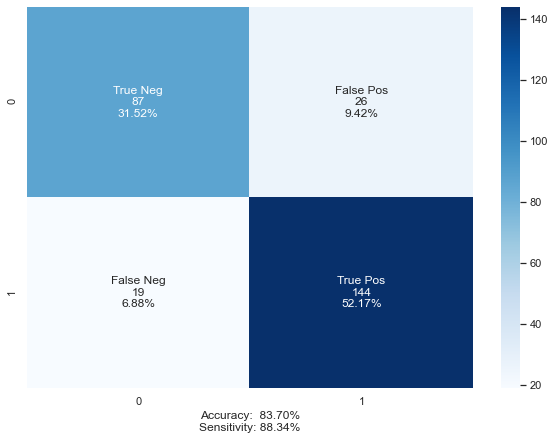

In [44]:
# dimensionality reduction
pca = PCA(0.70)
dataset_gnb_pca = pd.DataFrame(pca.fit_transform(dataset_gnb_std), 
                               columns = [f"Feature_{i}" for i in range(len(pca.components_))])

X = dataset_gnb_pca.copy()
y = dataset_gnb['HeartDisease']

model = GaussianNB()

y_test, y_pred, y_score_gnb = train_model(model, X, y)

# confusion matrix
plt.figure(figsize=(10,7))
conf_mat(y_test, y_pred, plot=True)
plt.show()

Unlike previous models, GNB seems to work better with the reduced dataset.

Finally, let's see whether k-fold cross validation with $k=5$ confirms these results.

In [45]:
X = dataset_gnb_std.copy()
y = dataset_gnb['HeartDisease']

model = GaussianNB()

mean_acc, mean_sens = kfold(model, X, y)

print(f"Mean Accuracy:    {mean_acc:.2f}%")
print(f"Mean Sensitivity: {mean_sens:.2f}%")

Mean Accuracy:    84.63%
Mean Sensitivity: 84.68%


The sensitivity is slightly lower but the overall accuracy is good.

## ROC curves comparison

By plotting all the ROC curves we can effectively all the models performed quite well, having an AUC (area under curve) greater than $0.9$.

It is astonishing looking at how well Decision Tree predicted the labels: its curve is basically a step function. Among the other models, KNN is visibly better than the other two, which on the other hand are very comparable. 

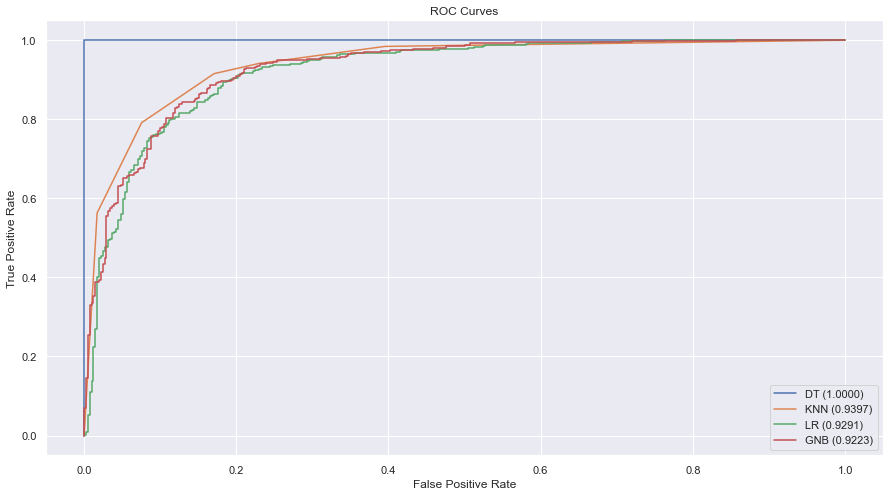

In [46]:
# decision tree
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y, y_score_dt)

# k nearest neighbors
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y, y_score_knn)

# logistic regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y, y_score_lr)

# gaussian naive bayes
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y, y_score_gnb)

plt.figure(figsize=(15,8))
plt.plot(fpr_dt, tpr_dt)
plt.plot(fpr_knn, tpr_knn)
plt.plot(fpr_gnb, tpr_gnb)
plt.plot(fpr_lr, tpr_lr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(labels=[f"DT ({auc(fpr_dt, tpr_dt):.4f}) ", 
                   f"KNN ({auc(fpr_knn, tpr_knn):.4f})",
                   f"LR ({auc(fpr_lr, tpr_lr):.4f})",
                   f"GNB ({auc(fpr_gnb, tpr_gnb):.4f})"])
plt.title("ROC Curves")
plt.show()

## Final results

The final results we obtained with k-fold Cross Validation for each model are:

1. Decision Tree
> Accuracy: 99%<br>
> Sensitivity: 99%<br>
> Area ROC Curve: 1.00
2. K-Nearest Neighbors
> Accuracy: 84%<br>
> Sensitivity: 87%<br>
> Area ROC Curve: 0.94
3. Logistic Regression
> Accuracy: 84%<br>
> Sensitivity: 86%<br>
> Area ROC Curve: 0.93
4. Gaussian Naïve Bayes
> Accuracy: 85%<br>
> Sensitivity: 85%<br>
> Area ROC Curve: 0.92